# Exploring Sog1 data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../data/sog1/all_shuffle_vars_JD.csv", index_col=0)
# Some shuffles give you the same sequence as another shuffle. 
# These sequences appear to be measured only the one time, so we'll drop all but the first
df.drop_duplicates(subset="tile_var", keep="first", inplace=True)
df.head()


pos_vals = pd.Series(
    np.vstack(df["Description_var"].str.split("pos").values)[:, 1]
    ).str.split("_", expand=True).astype(int)
pos_vals[0] *= 2
df.loc[:, ['shuffle_start', 'shuffle_idx']] = pos_vals.values
# Extract state sizes
shuffle_size = df["Description_var"].str.extract("(?<=_shuffle_size)(\d+)(?=_)").values.flatten().astype(int)
df["shuffle_size"] = shuffle_size
df['shuffle_size'].value_counts()

# Compute means
mean_activities_var = df[["Activity_S3_1_var", "Activity_S3_2_var"]].mean(axis=1).values.reshape(-1, 1)
std_activities_var = df[["Activity_S3_1_var", "Activity_S3_2_var"]].std(axis=1).values.reshape(-1, 1)

mean_activities_wt = df[["Activity_S3_1_wt", "Activity_S3_2_wt"]].mean(axis=1).values.reshape(-1, 1)
std_activities_wt = df[["Activity_S3_1_wt", "Activity_S3_2_wt"]].std(axis=1).values.reshape(-1, 1)

df[["activity_var", "std_var", "activity_wt", "std_wt"]] = np.hstack([mean_activities_var, std_activities_var, mean_activities_wt, std_activities_wt])

In [2]:
df['tile_wt'].unique()
print(df.shape)
df.head()

(3409, 16)


,Start,End,Description_var,tile_var,Activity_S3_1_var,Activity_S3_2_var,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,shuffle_start,shuffle_idx,shuffle_size,activity_var,std_var,activity_wt,std_wt
0,321,360,33_shuffle_size2_ss2_pos0_1,MELDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,763.760346,695.590132,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,0,1,2,729.675239,48.203620,815.218563,113.325689
1,321,360,33_shuffle_size2_ss2_pos1_1,EMDLDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1473.675797,1687.523804,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,2,1,2,1580.599801,151.213376,815.218563,113.325689
2,321,360,33_shuffle_size2_ss2_pos2_1,EMLDKDEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1706.977440,1719.464603,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,4,1,2,1713.221022,8.829758,815.218563,113.325689
3,321,360,33_shuffle_size2_ss2_pos4_1,EMLDDKEEEQKDRDNENQGEEDPTWFDSGSQFILNSQQLV,325.349781,627.000002,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,8,1,2,476.174892,213.298917,815.218563,113.325689
4,321,360,33_shuffle_size2_ss2_pos5_1,EMLDDKEEQEDKRDNENQGEEDPTWFDSGSQFILNSQQLV,677.584266,878.104555,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.0852,895.351926,10,1,2,777.844411,141.789256,815.218563,113.325689


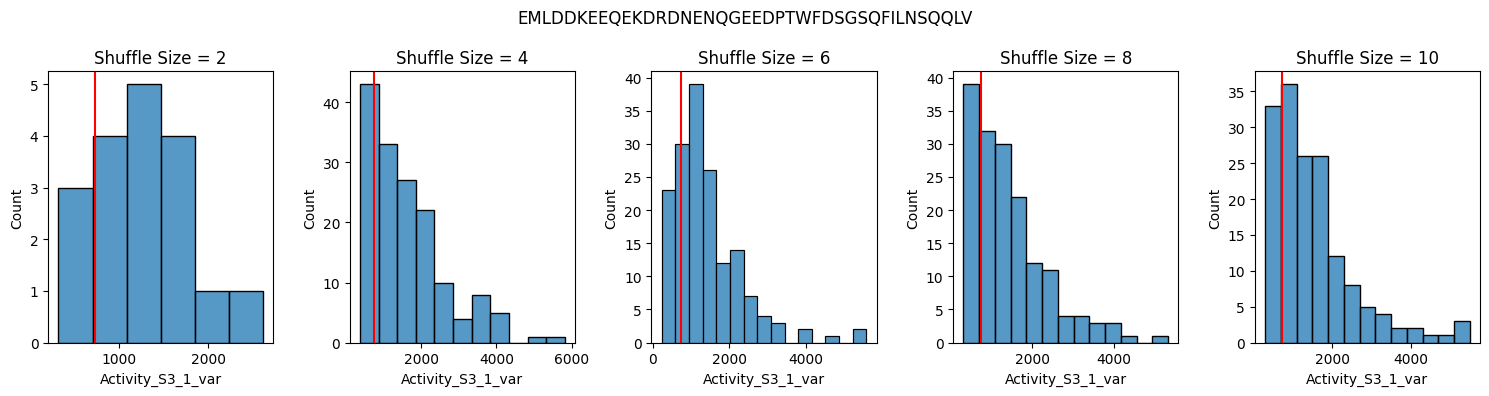

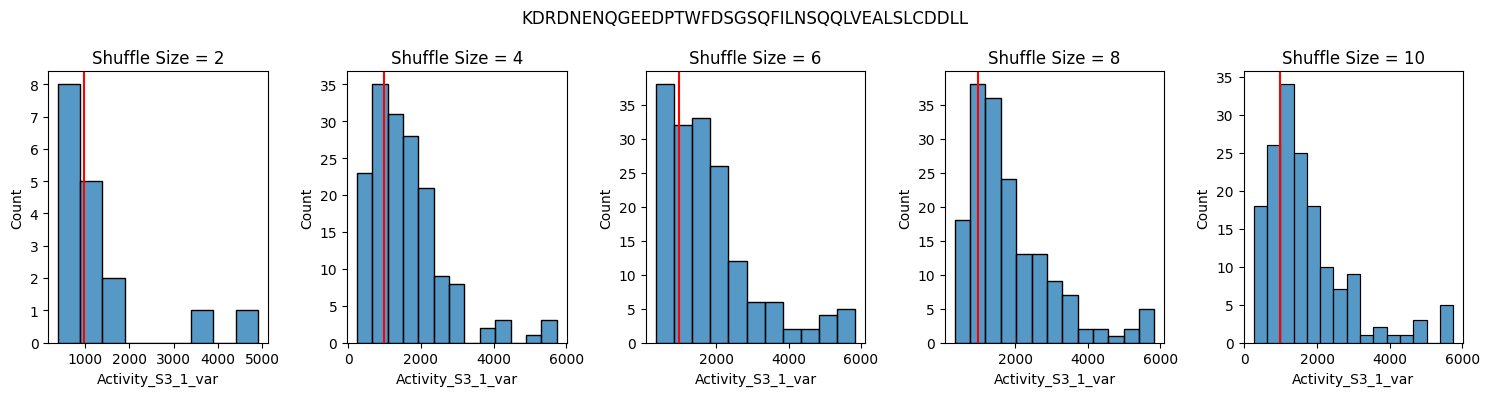

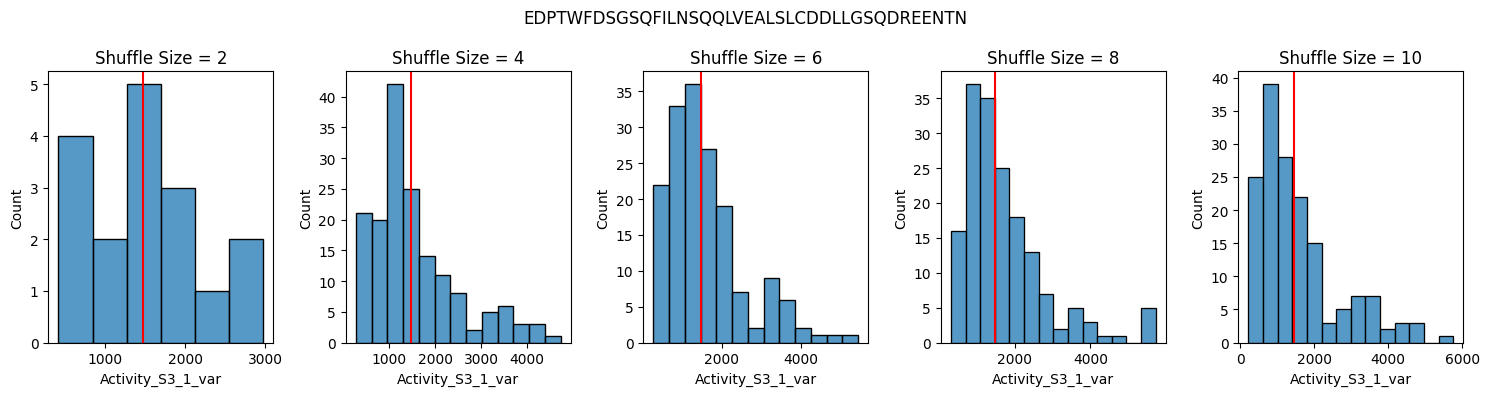

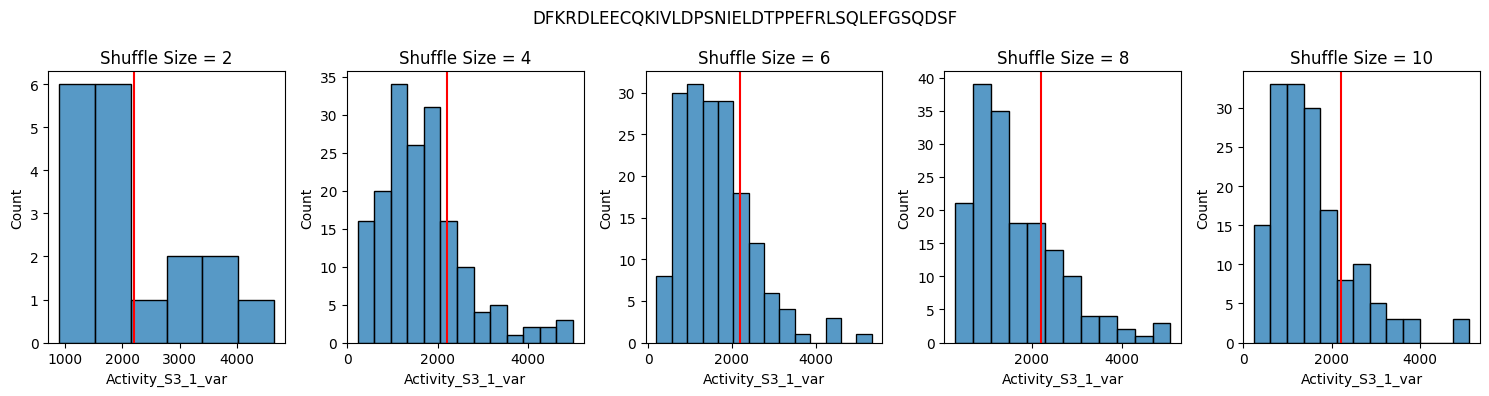

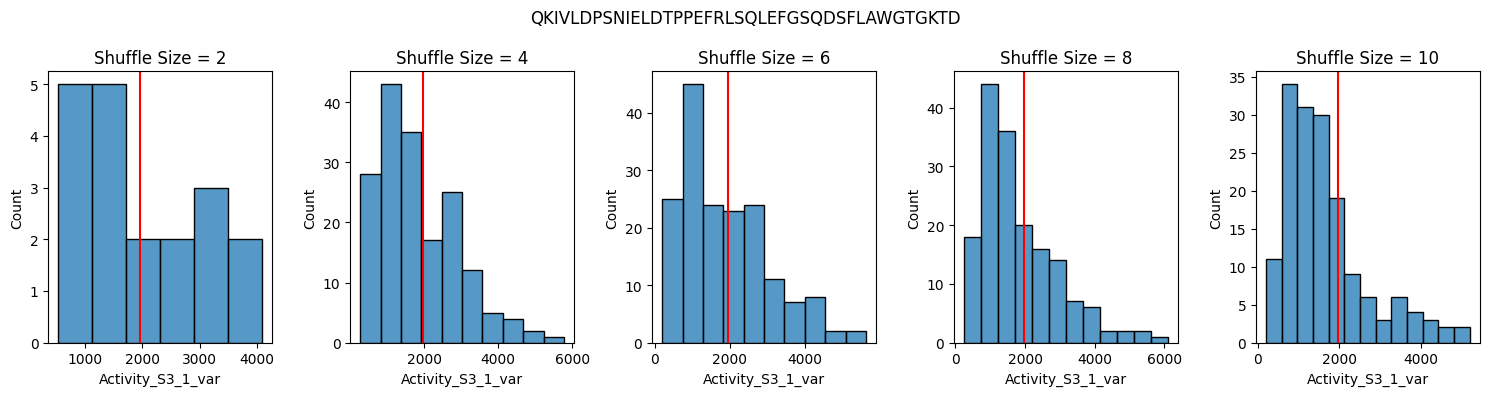

In [3]:
ss = 4 
seq = "EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV"

for seq in df["tile_wt"].unique():
    df_i = df.loc[(df["tile_wt"]==seq)]
    sss = df_i["shuffle_size"].unique()
    fig, axs = plt.subplots(1, len(sss), figsize=(3*len(sss), 4))
    for i, ss in enumerate(sss):
        df_ij = df_i.loc[(df_i["shuffle_size"] == ss)]
        sns.histplot(df_ij, x="Activity_S3_1_var", ax=axs[i])
        axs[i].axvline(df_ij["Activity_S3_1_wt"].unique().item(),
                    c='r',)
        axs[i].set_title(f"Shuffle Size = {ss}")
    plt.suptitle(seq)
    plt.tight_layout()
    plt.show()

In [4]:
import torch
from actpred.models import ActCNNSystem
kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("../adhunter/adhunter_1he.pt"))
model.eval()

df["pred"] = df["tile_var"].apply(lambda x: model(x).item())

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ADHunter doesn't perform well on this dataset.

Also, many of the 

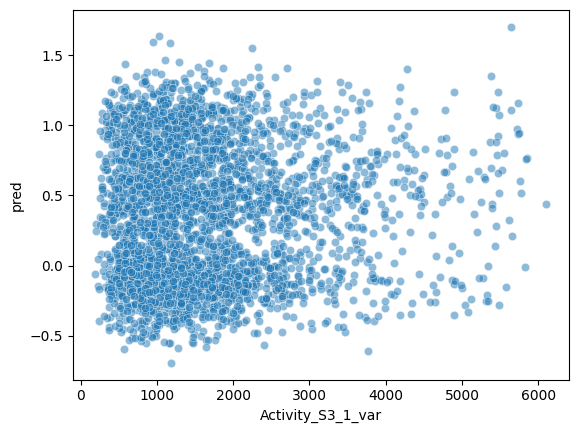

In [5]:
sns.scatterplot(df, x="Activity_S3_1_var", y="pred", alpha=0.5)
plt.show()

# sns.histplot(df, x="Activity_S3_1_var", alpha=.5)
# plt.show()

It seems like shuffling subsequences *increases* activity more than it decreases it, and this doesn't seem to be strongly dependent on the size of the shuffle

In [6]:
df

,Start,End,Description_var,tile_var,Activity_S3_1_var,Activity_S3_2_var,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,shuffle_start,shuffle_idx,shuffle_size,activity_var,std_var,activity_wt,std_wt,pred
0,321,360,33_shuffle_size2_ss2_pos0_1,MELDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,763.760346,695.590132,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,0,1,2,729.675239,48.203620,815.218563,113.325689,-0.108962
1,321,360,33_shuffle_size2_ss2_pos1_1,EMDLDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1473.675797,1687.523804,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,2,1,2,1580.599801,151.213376,815.218563,113.325689,-0.090604
2,321,360,33_shuffle_size2_ss2_pos2_1,EMLDKDEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1706.977440,1719.464603,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,4,1,2,1713.221022,8.829758,815.218563,113.325689,-0.093266
3,321,360,33_shuffle_size2_ss2_pos4_1,EMLDDKEEEQKDRDNENQGEEDPTWFDSGSQFILNSQQLV,325.349781,627.000002,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,8,1,2,476.174892,213.298917,815.218563,113.325689,-0.074402
4,321,360,33_shuffle_size2_ss2_pos5_1,EMLDDKEEQEDKRDNENQGEEDPTWFDSGSQFILNSQQLV,677.584266,878.104555,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,10,1,2,777.844411,141.789256,815.218563,113.325689,-0.006332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,410,449,42_shuffle_size10_ss2_pos15_6,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSLWTGADFGTK,908.291934,601.458747,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,6,10,754.875341,216.963828,1947.919950,21.017436,0.644748
3569,410,449,42_shuffle_size10_ss2_pos15_7,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTTKGDALWFG,3620.400685,3866.897601,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,7,10,3743.649143,174.299640,1947.919950,21.017436,0.476037
3570,410,449,42_shuffle_size10_ss2_pos15_8,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTLDFGKGATW,1014.433117,629.787497,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,8,10,822.110307,271.985526,1947.919950,21.017436,0.159170
3571,410,449,42_shuffle_size10_ss2_pos15_9,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTWFTGGADLK,2375.766170,1866.065374,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,9,10,2120.915772,360.412889,1947.919950,21.017436,0.291267


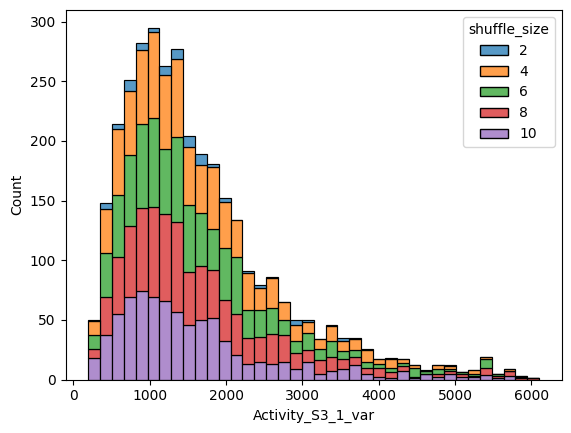

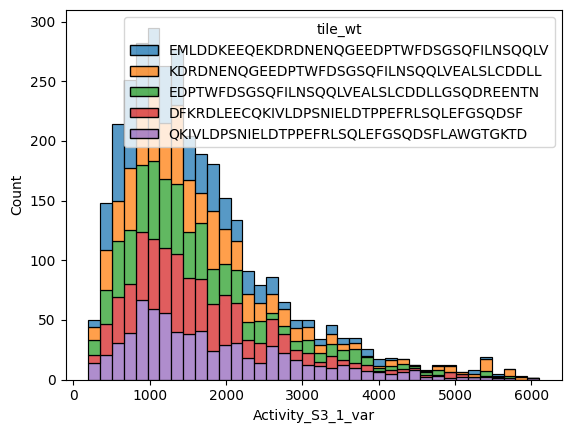

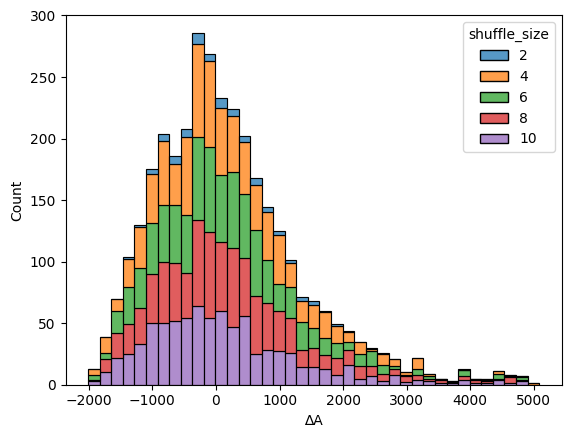

In [7]:
df["delta_a"] = df["Activity_S3_1_var"] - df["Activity_S3_1_wt"]
sns.histplot(df, x="Activity_S3_1_var", hue="shuffle_size", multiple="stack", palette="tab10")
# plt.xlabel("∆A")
plt.show()
sns.histplot(df, x="Activity_S3_1_var", hue="tile_wt", multiple="stack", palette="tab10")
# plt.xlabel("∆A")
plt.show()
sns.histplot(df, x="delta_a", hue="shuffle_size", multiple="stack", palette="tab10")
plt.xlabel("∆A")
plt.show()

# df

Let's look at correlation between shuffled segment similarity to original segment and ∆A

$$s = \frac{1}{shuffle size}\sum_i{1\{shuffled_i = original_i\}}$$

In [8]:
fn_shuffle = lambda row: row["tile_var"][row["shuffle_start"]:row["shuffle_start"]+row["shuffle_size"]]
fn_orig = lambda row: row["tile_wt"][row["shuffle_start"]:row["shuffle_start"]+row["shuffle_size"]]

df["shuffle_seq"] = df.apply(fn_shuffle, axis=1)
df["shuffle_seq_wt"] = df.apply(fn_orig, axis=1)
df

,Start,End,Description_var,tile_var,Activity_S3_1_var,Activity_S3_2_var,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,shuffle_start,shuffle_idx,shuffle_size,activity_var,std_var,activity_wt,std_wt,pred,delta_a,shuffle_seq,shuffle_seq_wt
0,321,360,33_shuffle_size2_ss2_pos0_1,MELDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,763.760346,695.590132,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,0,1,2,729.675239,48.203620,815.218563,113.325689,-0.108962,28.675146,ME,EM
1,321,360,33_shuffle_size2_ss2_pos1_1,EMDLDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1473.675797,1687.523804,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,2,1,2,1580.599801,151.213376,815.218563,113.325689,-0.090604,738.590597,DL,LD
2,321,360,33_shuffle_size2_ss2_pos2_1,EMLDKDEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1706.977440,1719.464603,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,4,1,2,1713.221022,8.829758,815.218563,113.325689,-0.093266,971.892240,KD,DK
3,321,360,33_shuffle_size2_ss2_pos4_1,EMLDDKEEEQKDRDNENQGEEDPTWFDSGSQFILNSQQLV,325.349781,627.000002,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,8,1,2,476.174892,213.298917,815.218563,113.325689,-0.074402,-409.735418,EQ,QE
4,321,360,33_shuffle_size2_ss2_pos5_1,EMLDDKEEQEDKRDNENQGEEDPTWFDSGSQFILNSQQLV,677.584266,878.104555,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,10,1,2,777.844411,141.789256,815.218563,113.325689,-0.006332,-57.500934,DK,KD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,410,449,42_shuffle_size10_ss2_pos15_6,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSLWTGADFGTK,908.291934,601.458747,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,6,10,754.875341,216.963828,1947.919950,21.017436,0.644748,-1054.489587,LWTGADFGTK,FLAWGTGKTD
3569,410,449,42_shuffle_size10_ss2_pos15_7,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTTKGDALWFG,3620.400685,3866.897601,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,7,10,3743.649143,174.299640,1947.919950,21.017436,0.476037,1657.619164,TTKGDALWFG,FLAWGTGKTD
3570,410,449,42_shuffle_size10_ss2_pos15_8,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTLDFGKGATW,1014.433117,629.787497,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,8,10,822.110307,271.985526,1947.919950,21.017436,0.159170,-948.348405,TLDFGKGATW,FLAWGTGKTD
3571,410,449,42_shuffle_size10_ss2_pos15_9,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTWFTGGADLK,2375.766170,1866.065374,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,9,10,2120.915772,360.412889,1947.919950,21.017436,0.291267,412.984649,TWFTGGADLK,FLAWGTGKTD


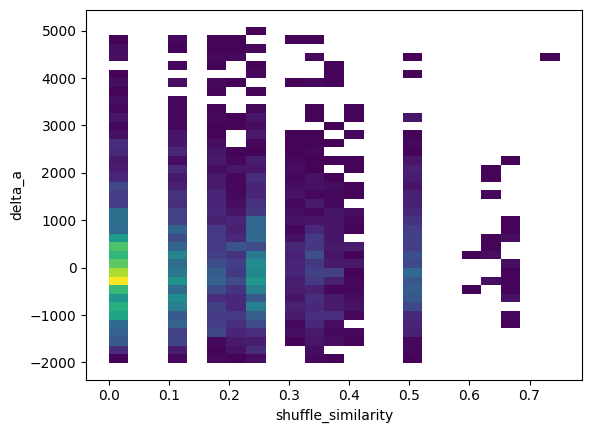

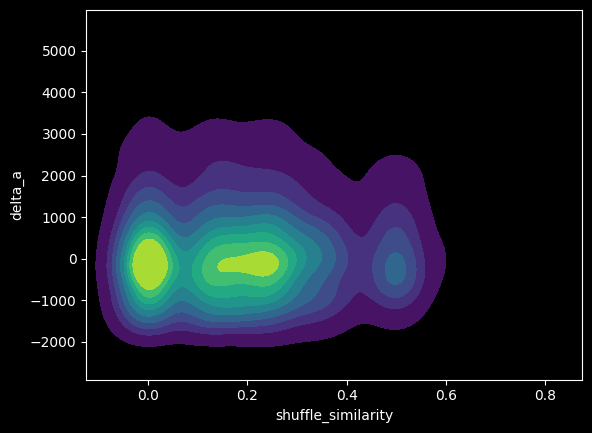

In [9]:
from collections import Counter
from math import factorial

perm = lambda seq: factorial(len(seq)) // np.prod([factorial(i) for i in Counter(seq).values()])
df["shuffle_seq"].apply(perm).value_counts()
# alphabet="ACDEFGHIKLMNPQRSTVWY"
# perm(alphabet[:10])

def similarity(s1, s2):
    assert len(s1) == len(s2)
    return sum([s1[i] == s2[i] for i in range(len(s1))]) / len(s1)

sims = [similarity(s1, s2) for (s1, s2) in df[["shuffle_seq", "shuffle_seq_wt"]].values]
df["shuffle_similarity"] = sims

sns.histplot(df, x="shuffle_similarity", y="delta_a", cmap="viridis")
plt.show()
with plt.style.context("dark_background"):
    sns.kdeplot(df, x="shuffle_similarity", y="delta_a", cmap="viridis", fill=True,)
    plt.show()

In [10]:
# import re
# from itertools import product
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

# count_kmers = lambda seq, pair: seq.count(pair)
# get_input_single = lambda seq: np.array([count_kmers(seq, aa) for aa in alphabet])
# X_aa = np.vstack(df["Seq"].apply(get_input_single).values)
# X_aa_train, X_aa_test, y_aa_train, y_aa_test = train_test_split(X_aa, y_cont, stratify=y_bin, train_size=.8)

# regr_single = LinearRegression()
# regr_single.fit(X_aa_train, y_aa_train)
# print(regr_single.score(X_aa_test, y_aa_test)) 

# Plot stuff

In [11]:
fn = "../data/sog1/all_shuffle_vars_JD.csv"

sog1_df = pd.read_csv(fn, index_col=0)
# Extract WT activations
wt_df = (pd.DataFrame(
    sog1_df
    .groupby("tile_wt")["Activity_S3_1_wt"]
    .unique())
    .reset_index()
    .rename(
        columns={"tile_wt": "Seq", "Activity_S3_1_wt": "Activity"}
    ))
wt_df["Activity"] = np.hstack(wt_df["Activity"].values)
# Extract activations from shuffled sequences
shuffled_df = (sog1_df[["tile_var", "Activity_S3_1_var"]]
 .copy()
 .rename(
     columns={"tile_var": "Seq", "Activity_S3_1_var": "Activity"}
 ))
adf = (
    pd.concat([shuffled_df, wt_df], keys=['shuffled', 'wt'], names=["type"])
    .reset_index()
    .drop("level_1", axis=1))

### Pairwise shuffles
Is there any obvious trend emerging from 2mer shuffling?

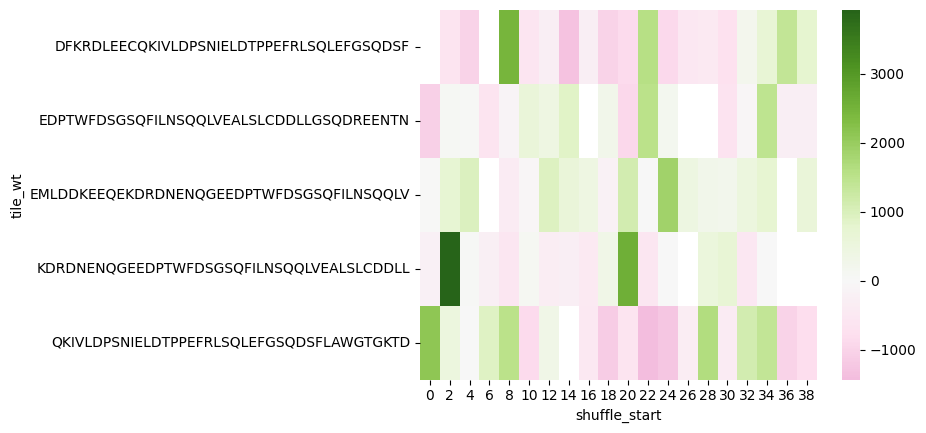

In [12]:
df2 = df[df["shuffle_size"] == 2].copy()
df2_p = pd.pivot_table(df2, index="tile_wt", columns="shuffle_start", values="delta_a")
sns.heatmap(df2_p, cmap="PiYG", center=0)
plt.show()

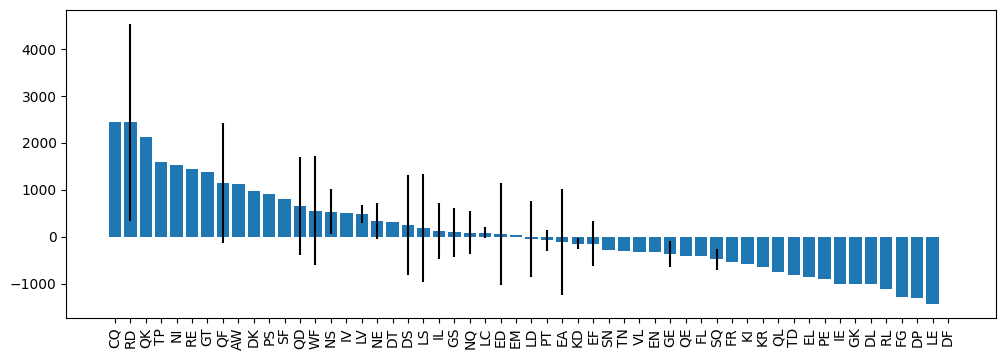

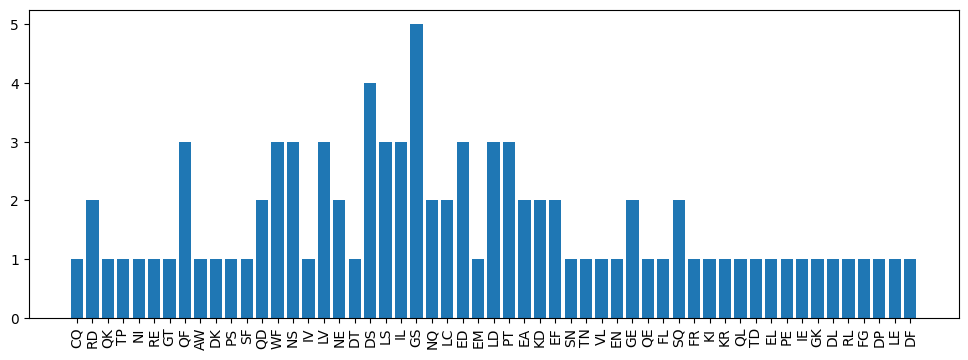

In [13]:
means = df2.groupby("shuffle_seq_wt")["delta_a"].mean().sort_values(ascending=False).fillna(0)
stds = df2.groupby("shuffle_seq_wt")["delta_a"].std().loc[means.index].fillna(0)

plt.figure(figsize=(12,4))
plt.bar(x=means.index, height=means.values, yerr=stds.values)
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(12,4))
cts = df2["shuffle_seq_wt"].value_counts().loc[means.index]
plt.bar(cts.index, cts.values)
plt.xticks(rotation=90)
plt.show()

# Fold change

In [14]:
# import matplotlib
fcs = np.log2(df["activity_var"] / df["activity_wt"]).fillna(0)
df["logfc"] = fcs
# sns.histplot(fcs, stat="probability")
# plt.ylabel(r"$log_{2}FC$")
# plt.show()
df

,Start,End,Description_var,tile_var,Activity_S3_1_var,Activity_S3_2_var,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,shuffle_start,...,activity_var,std_var,activity_wt,std_wt,pred,delta_a,shuffle_seq,shuffle_seq_wt,shuffle_similarity,logfc
0,321,360,33_shuffle_size2_ss2_pos0_1,MELDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,763.760346,695.590132,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,0,...,729.675239,48.203620,815.218563,113.325689,-0.108962,28.675146,ME,EM,0.0,-0.159932
1,321,360,33_shuffle_size2_ss2_pos1_1,EMDLDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1473.675797,1687.523804,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,2,...,1580.599801,151.213376,815.218563,113.325689,-0.090604,738.590597,DL,LD,0.0,0.955213
2,321,360,33_shuffle_size2_ss2_pos2_1,EMLDKDEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1706.977440,1719.464603,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,4,...,1713.221022,8.829758,815.218563,113.325689,-0.093266,971.892240,KD,DK,0.0,1.071452
3,321,360,33_shuffle_size2_ss2_pos4_1,EMLDDKEEEQKDRDNENQGEEDPTWFDSGSQFILNSQQLV,325.349781,627.000002,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,8,...,476.174892,213.298917,815.218563,113.325689,-0.074402,-409.735418,EQ,QE,0.0,-0.775695
4,321,360,33_shuffle_size2_ss2_pos5_1,EMLDDKEEQEDKRDNENQGEEDPTWFDSGSQFILNSQQLV,677.584266,878.104555,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,10,...,777.844411,141.789256,815.218563,113.325689,-0.006332,-57.500934,DK,KD,0.0,-0.067705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,410,449,42_shuffle_size10_ss2_pos15_6,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSLWTGADFGTK,908.291934,601.458747,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,...,754.875341,216.963828,1947.919950,21.017436,0.644748,-1054.489587,LWTGADFGTK,FLAWGTGKTD,0.1,-1.367624
3569,410,449,42_shuffle_size10_ss2_pos15_7,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTTKGDALWFG,3620.400685,3866.897601,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,...,3743.649143,174.299640,1947.919950,21.017436,0.476037,1657.619164,TTKGDALWFG,FLAWGTGKTD,0.0,0.942511
3570,410,449,42_shuffle_size10_ss2_pos15_8,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTLDFGKGATW,1014.433117,629.787497,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,...,822.110307,271.985526,1947.919950,21.017436,0.159170,-948.348405,TLDFGKGATW,FLAWGTGKTD,0.4,-1.244531
3571,410,449,42_shuffle_size10_ss2_pos15_9,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTWFTGGADLK,2375.766170,1866.065374,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,...,2120.915772,360.412889,1947.919950,21.017436,0.291267,412.984649,TWFTGGADLK,FLAWGTGKTD,0.1,0.122753


Shapiro-Wilk Test Statistic: 0.998345806595301
P-value: 0.0013573556618822933
The data does not follow a normal distribution.


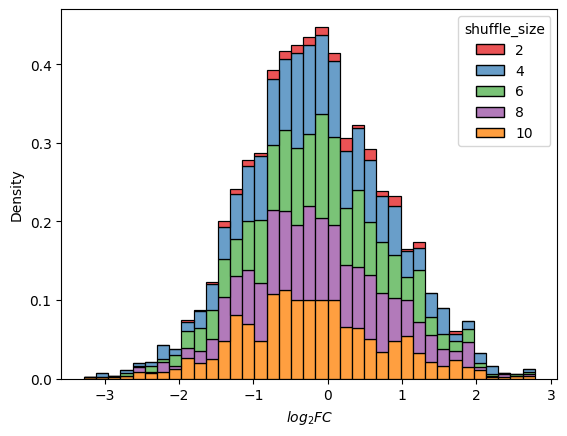

In [15]:
from scipy.stats import shapiro, norm

stat, p_value = shapiro(fcs)
print(f"Shapiro-Wilk Test Statistic: {stat}")
print(f"P-value: {p_value}")
if p_value > 0.05:
    print("The data likely follows a normal distribution.")
else:
    print("The data does not follow a normal distribution.")

xbar, std = norm.fit(fcs)
x = np.linspace(min(fcs), max(fcs)+.1, 100)
y = norm.pdf(x, loc=xbar, scale=std)


sns.histplot(df, x="logfc", hue="shuffle_size", stat="density", multiple="stack", palette="Set1")
plt.xlabel(r"$log_{2}FC$")
if p_value > 0.05:
    plt.plot(x, y, c='k')
plt.show()

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_3622/2665623602.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df, y="logfc", x="shuffle_size", palette="Set1")


<Axes: xlabel='shuffle_size', ylabel='logfc'>

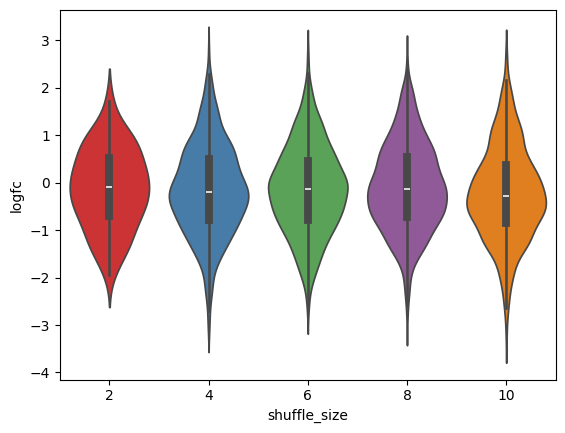

In [16]:
sns.violinplot(df, y="logfc", x="shuffle_size", palette="Set1")

In [17]:
from scipy.optimize import curve_fit
from scipy.stats import norm

def gaussian(x, mean, std):
    return norm.pdf(x, loc=mean, scale=std)

x_data = np.arange(len(fcs))
data = fcs.values
popt, pcov = curve_fit(gaussian, x_data, data)
# fcs.values
r_squared = 1 - (np.sum((data - gaussian(x_data, *popt))**2) / np.sum((data - np.mean(data))**2))
print(f"R-squared: {r_squared}")


R-squared: -0.025577984524842057


In [18]:
# sns.histplot(np.log2(df["Activity_S3_1_var"] / df["Activity_S3_2_var"]))

df


,Start,End,Description_var,tile_var,Activity_S3_1_var,Activity_S3_2_var,tile_wt,Activity_S3_1_wt,Activity_S3_2_wt,shuffle_start,...,activity_var,std_var,activity_wt,std_wt,pred,delta_a,shuffle_seq,shuffle_seq_wt,shuffle_similarity,logfc
0,321,360,33_shuffle_size2_ss2_pos0_1,MELDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,763.760346,695.590132,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,0,...,729.675239,48.203620,815.218563,113.325689,-0.108962,28.675146,ME,EM,0.0,-0.159932
1,321,360,33_shuffle_size2_ss2_pos1_1,EMDLDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1473.675797,1687.523804,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,2,...,1580.599801,151.213376,815.218563,113.325689,-0.090604,738.590597,DL,LD,0.0,0.955213
2,321,360,33_shuffle_size2_ss2_pos2_1,EMLDKDEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,1706.977440,1719.464603,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,4,...,1713.221022,8.829758,815.218563,113.325689,-0.093266,971.892240,KD,DK,0.0,1.071452
3,321,360,33_shuffle_size2_ss2_pos4_1,EMLDDKEEEQKDRDNENQGEEDPTWFDSGSQFILNSQQLV,325.349781,627.000002,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,8,...,476.174892,213.298917,815.218563,113.325689,-0.074402,-409.735418,EQ,QE,0.0,-0.775695
4,321,360,33_shuffle_size2_ss2_pos5_1,EMLDDKEEQEDKRDNENQGEEDPTWFDSGSQFILNSQQLV,677.584266,878.104555,EMLDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV,735.085200,895.351926,10,...,777.844411,141.789256,815.218563,113.325689,-0.006332,-57.500934,DK,KD,0.0,-0.067705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3568,410,449,42_shuffle_size10_ss2_pos15_6,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSLWTGADFGTK,908.291934,601.458747,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,...,754.875341,216.963828,1947.919950,21.017436,0.644748,-1054.489587,LWTGADFGTK,FLAWGTGKTD,0.1,-1.367624
3569,410,449,42_shuffle_size10_ss2_pos15_7,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTTKGDALWFG,3620.400685,3866.897601,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,...,3743.649143,174.299640,1947.919950,21.017436,0.476037,1657.619164,TTKGDALWFG,FLAWGTGKTD,0.0,0.942511
3570,410,449,42_shuffle_size10_ss2_pos15_8,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTLDFGKGATW,1014.433117,629.787497,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,...,822.110307,271.985526,1947.919950,21.017436,0.159170,-948.348405,TLDFGKGATW,FLAWGTGKTD,0.4,-1.244531
3571,410,449,42_shuffle_size10_ss2_pos15_9,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSTWFTGGADLK,2375.766170,1866.065374,QKIVLDPSNIELDTPPEFRLSQLEFGSQDSFLAWGTGKTD,1962.781522,1933.058378,30,...,2120.915772,360.412889,1947.919950,21.017436,0.291267,412.984649,TWFTGGADLK,FLAWGTGKTD,0.1,0.122753


# Phosphorylation

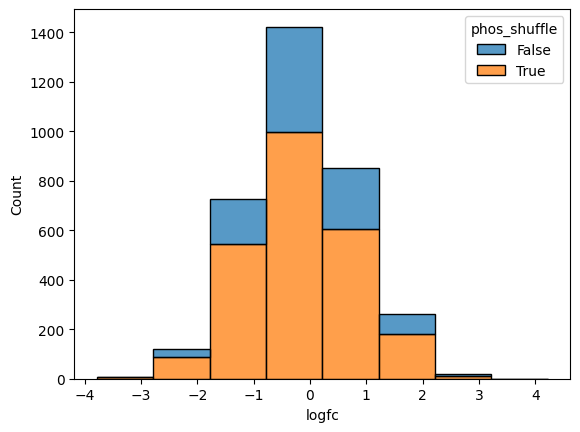

/var/folders/1w/3zhjqj3d3ljgvrrqp77lpv6m0000gn/T/ipykernel_3622/752609036.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_proportions = df.groupby(['binned', 'phos_shuffle']).size().unstack(fill_value=0)


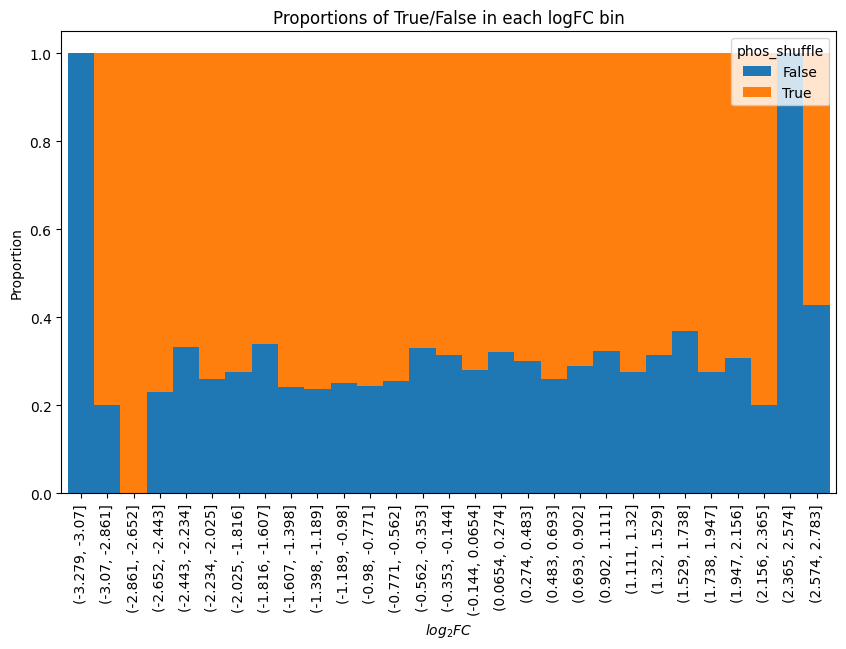

In [19]:
df["phos_shuffle"] = df["shuffle_seq"].str.contains("S|T|Y")
sns.histplot(df, x="logfc", hue="phos_shuffle", stat="count", multiple="stack", discrete=True)
plt.show()


# CHAT STUFF
bins = np.linspace(df['logfc'].min(), df['logfc'].max(), 30)  # Adjust number of bins as needed

# Step 2: Bin the data and calculate the proportion of True/False in each bin
df['binned'] = pd.cut(df['logfc'], bins=bins)

# Step 3: Calculate proportions of True/False in each bin
bin_proportions = df.groupby(['binned', 'phos_shuffle']).size().unstack(fill_value=0)

# Normalize the counts to get proportions (sum of each bin will be 1)
bin_proportions = bin_proportions.div(bin_proportions.sum(axis=1), axis=0)

# Step 4: Plot the proportions as stacked bars
bin_proportions.plot(kind='bar', stacked=True, width=1, figsize=(10, 6))

# Step 5: Labeling the plot
plt.xlabel(r"$log_{2}FC$")
plt.ylabel("Proportion")
plt.title("Proportions of True/False in each logFC bin")

# Show the plot
plt.show()

In [20]:
swt = df["tile_wt"].unique()[1]
print(f">WT\n{swt}")
# for i, s in df.loc[(df["tile_wt"]==swt) & (df["shuffle_size"]==2), "tile_var"].items():
for i, s in df.loc[(df["tile_wt"]==swt), "tile_var"].items():
    print(f">s{i}\n{s}")

>WT
KDRDNENQGEEDPTWFDSGSQFILNSQQLVEALSLCDDLL
>s18
DKRDNENQGEEDPTWFDSGSQFILNSQQLVEALSLCDDLL
>s19
KDDRNENQGEEDPTWFDSGSQFILNSQQLVEALSLCDDLL
>s20
KDRDENNQGEEDPTWFDSGSQFILNSQQLVEALSLCDDLL
>s21
KDRDNEQNGEEDPTWFDSGSQFILNSQQLVEALSLCDDLL
>s22
KDRDNENQEGEDPTWFDSGSQFILNSQQLVEALSLCDDLL
>s23
KDRDNENQGEDEPTWFDSGSQFILNSQQLVEALSLCDDLL
>s24
KDRDNENQGEEDTPWFDSGSQFILNSQQLVEALSLCDDLL
>s25
KDRDNENQGEEDPTFWDSGSQFILNSQQLVEALSLCDDLL
>s26
KDRDNENQGEEDPTWFSDGSQFILNSQQLVEALSLCDDLL
>s27
KDRDNENQGEEDPTWFDSSGQFILNSQQLVEALSLCDDLL
>s28
KDRDNENQGEEDPTWFDSGSFQILNSQQLVEALSLCDDLL
>s29
KDRDNENQGEEDPTWFDSGSQFLINSQQLVEALSLCDDLL
>s30
KDRDNENQGEEDPTWFDSGSQFILSNQQLVEALSLCDDLL
>s31
KDRDNENQGEEDPTWFDSGSQFILNSQQVLEALSLCDDLL
>s32
KDRDNENQGEEDPTWFDSGSQFILNSQQLVAELSLCDDLL
>s33
KDRDNENQGEEDPTWFDSGSQFILNSQQLVEASLLCDDLL
>s34
KDRDNENQGEEDPTWFDSGSQFILNSQQLVEALSCLDDLL
>s236
RDDKNENQGEEDPTWFDSGSQFILNSQQLVEALSLCDDLL
>s237
KRDDNENQGEEDPTWFDSGSQFILNSQQLVEALSLCDDLL
>s238
DDRKNENQGEEDPTWFDSGSQFILNSQQLVEALSLCDDLL
>s239
DDKRNENQGEEDPTWFDSGSQFILNS

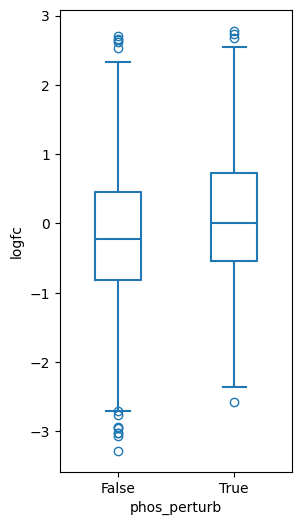

In [21]:
# import re

# regex = r'(.{0,4})(S|T|Y)(.{0,4})'
# def find_matches(text):
#     matches = re.findall(regex, text)
#     return [before + match + after for before, match, after in matches]
# df["tile_var"].apply(find_matches)
# df["tile_var"]
phos_resns = ["S", "T", "Y"]

# re.findall(regex, )
# np.where(np.array(list("MELDDKEEQEKDRDNENQGEEDPTWFDSGSQFILNSQQLV")) in (phos_resns))
find = lambda seq, n=4: [seq[i-n:i+n+1] for i in range(len(seq)) if seq[i] in phos_resns]
# seq
df["phos_perturb"] = df["tile_var"].apply(find) == df["tile_wt"].apply(find)
# sns.histplot(df, x="logfc", hue="phos_perturb", stat="count", multiple="stack", discrete=True)
# plt.show()
plt.figure(figsize=(3,6))
sns.boxplot(df, x="phos_perturb", y="logfc", width=.4, fill=None, )
# plt.tight_layout()
plt.show()

# KMers

In [22]:
# import re
# from itertools import product
# alphabet="ACDEFGHIKLMNPQRSTVWY"
# count_kmers = lambda seq, pair: len(re.findall(f'(?=({pair}))', seq))
# dipeptides = ["".join(j) for j in [i for i in product(alphabet, repeat=2)]]
# get_input_2mers_all = lambda seq: np.array([count_kmers(seq, pair) for pair in dipeptides])

# # X_2mers = np.vstack(df["Seq"].apply(get_input_2mers).values)
# X_2mers = np.vstack(df["tile_var"].apply(get_input_2mers_all).values)
# # df
# pd.DataFrame(X_2mers, columns=dipeptides)

In [22]:
alphabet="ACDEFGHIKLMNPQRSTVWY"
# def get_kmers(seq, k):
#     # return [seq[i:i+k] for i in range(len(seq)-k+1)]
#     return pd.Series([seq[i:i+k] for i in range(len(seq)-k+1)]).value_counts()

# # get_kmers(seq, 3)
# k=4
# # seq_wt = df["tile_wt"].unique()[0]
# df0 = df#df[df["tile_wt"]==seq_wt]
# # df0["tile_wt"].apply(get_kmers, k=3)
# kdf0 = df0["tile_var"].apply(get_kmers, k=k).fillna(0).astype(int)
# # kdf0.corr()
# kdf0["logfc"] = df["logfc"] > 0.5
# # kdf0["logfc"] = df["logfc"] < -0.5
# # kdf0 = kdf0.sort_values(by="logfc")
# # sns.heatmap(kdf0.astype(int))
# # kdf0
# kdf0[kdf0.columns[:-1]].corrwith(kdf0["logfc"]).sort_values(ascending=False)
# # sns.heatmap(kdf0, cmap="viridis")
# # [i for i in alphabet if i not in df0["tile_wt"].apply(lambda x: pd.Series(list(x)).value_counts()).columns]# np.shuffle("AAABB")
# # 20**3

# kmer_counts = kdf0.groupby("logfc").sum()
# # (kmer_counts / kmer_counts.sum(axis=0)).sum(axis=1)
# dks = kmer_counts.loc[True] - kmer_counts.loc[False]
# dks.sort_values(ascending=False)
# # kmer_props = (kmer_counts.T / kmer_counts.sum(axis=1)).T
# # kmerfcs = kmer_props.loc[True] / kmer_props.loc[False]
# # kmerfcs.sort_values(ascending=False).head(20)

It might be more informative to look at *variable region* kmers: kmers that overlap the shuffled indices, since that tells us which ones are created/destroyed in the shuffle

In [23]:

# df.columns


# var_kmers = var_seqs.apply(get_kmers, k=k).fillna(0).astype(int)
# wt_kmers = wt_seqs.apply(get_kmers, k=k).fillna(0).astype(int)
# missing_in_var = wt_kmers.columns.difference(var_kmers.columns)
# missing_in_wt = var_kmers.columns.difference(wt_kmers.columns)
# var_kmers[missing_in_var] = 0
# wt_kmers[missing_in_wt] = 0
# var_kmers = var_kmers.loc[:, wt_kmers.columns]


# sns.heatmap(dks, xticklabels=False, yticklabels=False, cmap=['y', 'k', 'c',], center=0)
# plt.show()

In [24]:
df.columns

Index(['Start', 'End', 'Description_var', 'tile_var', 'Activity_S3_1_var',
       'Activity_S3_2_var', 'tile_wt', 'Activity_S3_1_wt', 'Activity_S3_2_wt',
       'shuffle_start', 'shuffle_idx', 'shuffle_size', 'activity_var',
       'std_var', 'activity_wt', 'std_wt', 'pred', 'delta_a', 'shuffle_seq',
       'shuffle_seq_wt', 'shuffle_similarity', 'logfc', 'phos_shuffle',
       'binned', 'phos_perturb'],
      dtype='object')

In [25]:
import warnings
warnings.filterwarnings("ignore")

def get_var_region(row, k, seq_col="tile_var"):
    start = row["shuffle_start"]
    end = start + row["shuffle_size"]
    start = max(0, start-k)
    end = min(40, end+k-1)
    return row[seq_col][start:end]


def get_kmers(seq, k):
    return [seq[i:i+k] for i in range(len(seq)-k+1)]

k = 4
var_seqs = df.apply(get_var_region, k=k, axis=1)
wt_seqs = df.apply(get_var_region, k=k, axis=1, seq_col="tile_wt")

var_kmers = var_seqs.apply(get_kmers, k=k).values
wt_kmers = wt_seqs.apply(get_kmers, k=k).values
# Determine new kmers created in each var sequence
new_kmers = []
for i in range(len(var_kmers)):
    nki = [j for j in var_kmers[i] if j not in wt_kmers[i]]
    new_kmers.append(nki)

new_kmers_df = (pd.DataFrame(
    pd.Series(new_kmers)
    .apply(Counter)
    .to_dict())
    .fillna(0)
    .astype(int)
    .T)
new_kmers_df["logfc"] = df["logfc"]

max_cts = new_kmers_df.iloc[:, :-1].max()
print(f"max counts of kmers in single sequence:\n{max_cts[max_cts > 1]}")

new_kmers_df.head()


max counts of kmers in single sequence:
EEKD    2
LSQF    2
dtype: int64


,MELD,ELDD,EMDL,MDLD,DLDK,LDKE,MLDK,LDKD,DKDE,KDEE,...,ADLK,SLFT,LFTK,FTKA,TKAG,KAGD,AGDT,GDTW,DTWG,logfc
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.159932
1,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.955213
2,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1.071452
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.775695
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.067705


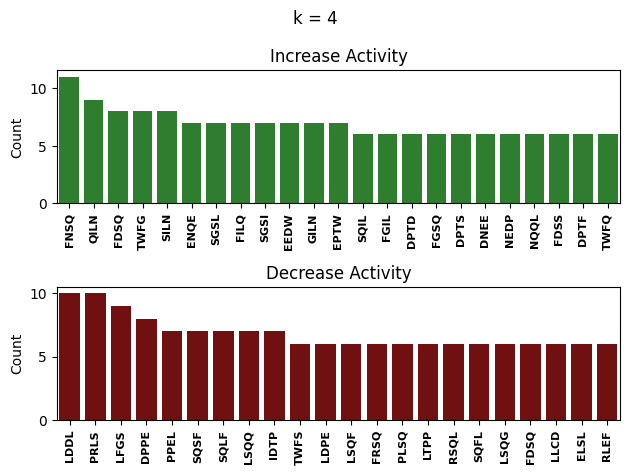

In [26]:
lfc_thresh=1
sig_changes = new_kmers_df.loc[(new_kmers_df["logfc"] > lfc_thresh) | (new_kmers_df["logfc"] < -lfc_thresh)]
sig_changes = sig_changes.groupby(sig_changes["logfc"] > lfc_thresh).sum().iloc[:, :-1]
count_thresh=5
act_ups = sig_changes.loc[(True), (sig_changes.loc[True] > count_thresh)].sort_values(ascending=False)
act_downs = sig_changes.loc[(False), (sig_changes.loc[False] > count_thresh)].sort_values(ascending=False)
# act_downs
# plt.figure(figsize=(15,3))
# fig, axs = plt.subplots(2, 1, figsize=(8,6))
plt.figure()
plt.subplot(2, 1, 1)
sns.barplot(act_ups, color='forestgreen',)
plt.xticks(rotation=90, fontsize=8, fontweight="bold")
plt.title("Increase Activity")
plt.ylabel("Count")

plt.subplot(2, 1, 2)
sns.barplot(act_downs, color='maroon')
plt.xticks(rotation=90, fontsize=8, fontweight="bold")
plt.title("Decrease Activity")
plt.ylabel("Count")
plt.suptitle(f"k = {k}")
plt.tight_layout()
plt.show()

max counts of kmers in single sequence:
EEKD    2
LSQF    2
dtype: int64


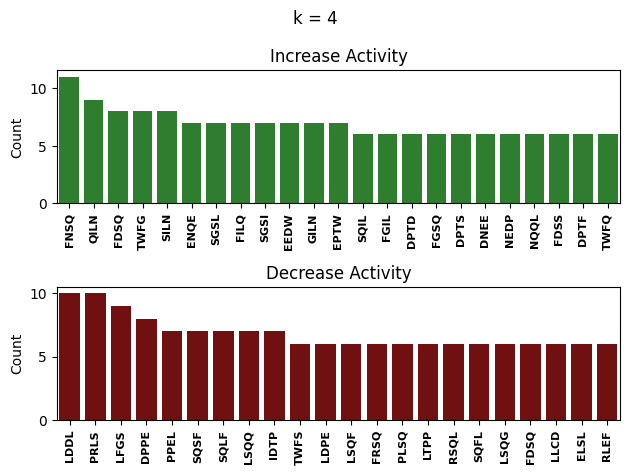

max counts of kmers in single sequence:
Series([], dtype: int64)


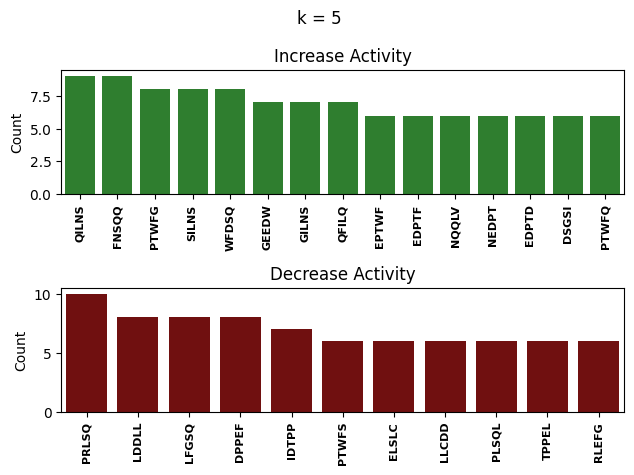

max counts of kmers in single sequence:
DLD    2
DEN    2
EEK    2
KED    2
SQL    2
QSL    2
SLD    2
LLD    2
LLL    2
LDL    2
ELQ    2
LQL    2
IDL    2
SQF    2
dtype: int64


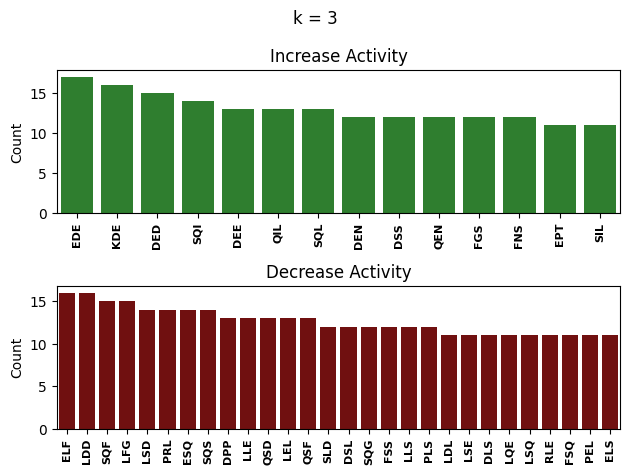

max counts of kmers in single sequence:
EL    2
DL    2
DE    3
ED    2
DD    2
EP    2
FS    2
SD    2
SS    2
SF    2
FQ    2
FL    2
LE    2
LL    2
LD    2
SG    2
EK    2
ND    2
QS    2
LF    2
LQ    2
SL    2
ES    2
FE    2
QF    2
ID    2
PL    2
dtype: int64


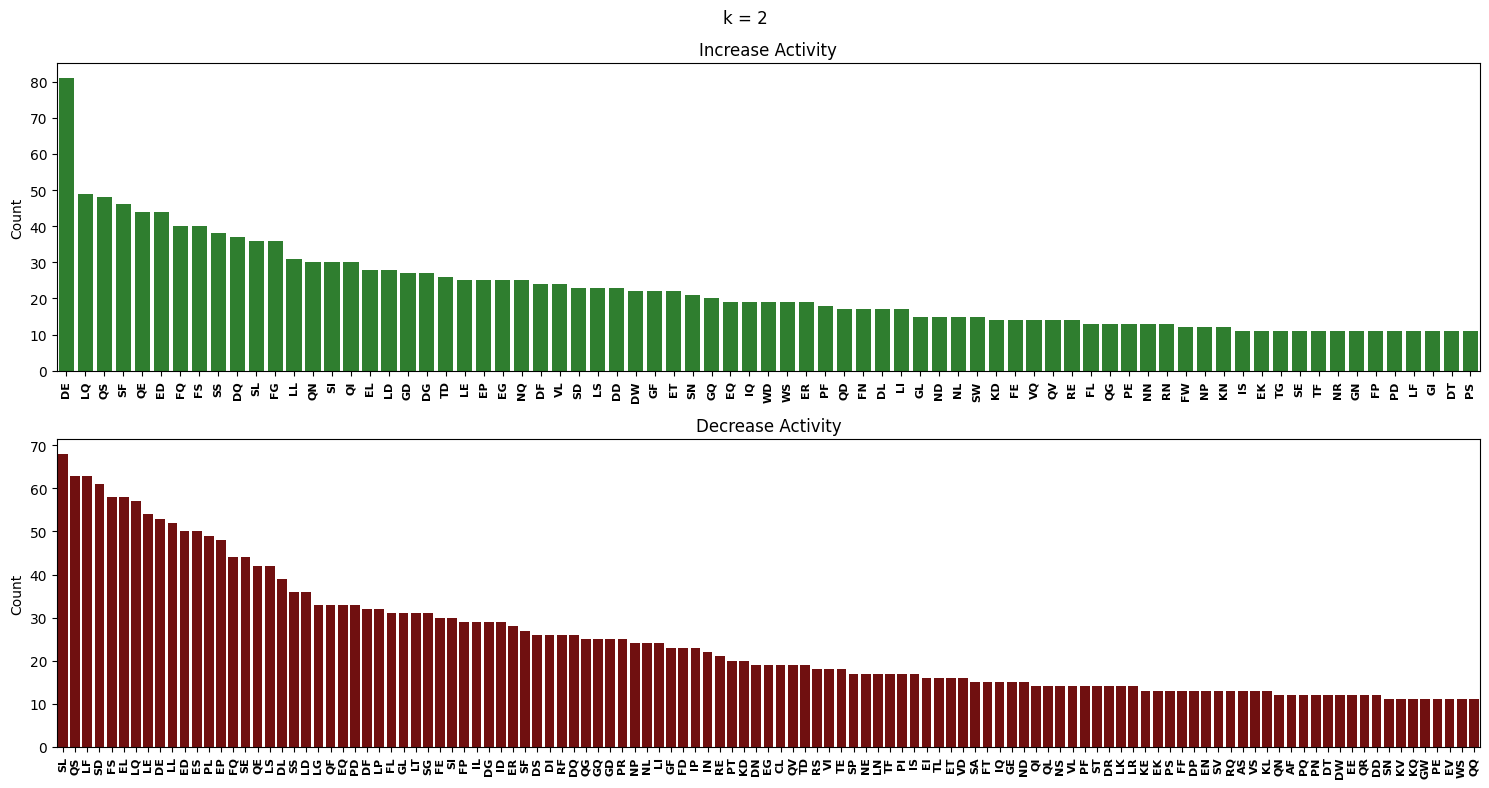

In [27]:
def get_new_kmers(k):
    var_seqs = df.apply(get_var_region, k=k, axis=1)
    wt_seqs = df.apply(get_var_region, k=k, axis=1, seq_col="tile_wt")

    var_kmers = var_seqs.apply(get_kmers, k=k).values
    wt_kmers = wt_seqs.apply(get_kmers, k=k).values
    # Determine new kmers created in each var sequence
    new_kmers = []
    for i in range(len(var_kmers)):
        nki = [j for j in var_kmers[i] if j not in wt_kmers[i]]
        new_kmers.append(nki)

    new_kmers_df = (pd.DataFrame(
        pd.Series(new_kmers)
        .apply(Counter)
        .to_dict())
        .fillna(0)
        .astype(int)
        .T)
    new_kmers_df["logfc"] = df["logfc"]
    return new_kmers_df


def kmer_plot(k, lfc_thresh=1, count_thresh=5):
    new_kmers_df = get_new_kmers(k)

    max_cts = new_kmers_df.iloc[:, :-1].max()
    print(f"max counts of kmers in single sequence:\n{max_cts[max_cts > 1]}")
    # Find kmers associated with changes of greater magnitude than lfc_threshold
    sig_changes = new_kmers_df.loc[(new_kmers_df["logfc"] > lfc_thresh) | (new_kmers_df["logfc"] < -lfc_thresh)]
    sig_changes = sig_changes.groupby(sig_changes["logfc"] > lfc_thresh).sum().iloc[:, :-1]
    act_ups = sig_changes.loc[(True), (sig_changes.loc[True] > count_thresh)].sort_values(ascending=False)
    act_downs = sig_changes.loc[(False), (sig_changes.loc[False] > count_thresh)].sort_values(ascending=False)
    # Plot stuff
    # plt.figure()
    plt.subplot(2, 1, 1)
    sns.barplot(act_ups, color='forestgreen',)
    plt.xticks(rotation=90, fontsize=8, fontweight="bold")
    plt.title("Increase Activity")
    plt.ylabel("Count")

    plt.subplot(2, 1, 2)
    sns.barplot(act_downs, color='maroon')
    plt.xticks(rotation=90, fontsize=8, fontweight="bold")
    plt.title("Decrease Activity")
    plt.ylabel("Count")
    plt.suptitle(f"k = {k}")
    plt.tight_layout()
    plt.show()

kmer_plot(4)
kmer_plot(5)
kmer_plot(3, count_thresh=10)
plt.figure(figsize=(15,8))
kmer_plot(2, count_thresh=10)

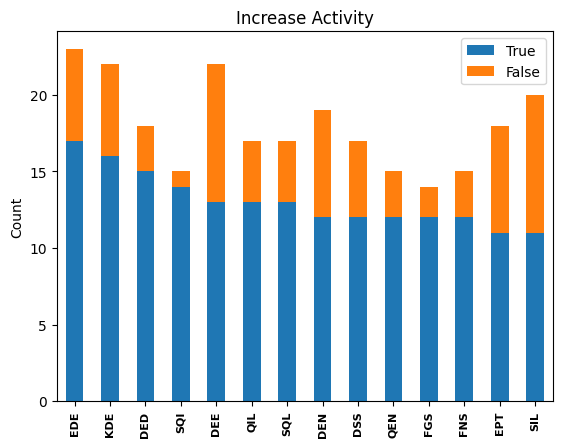

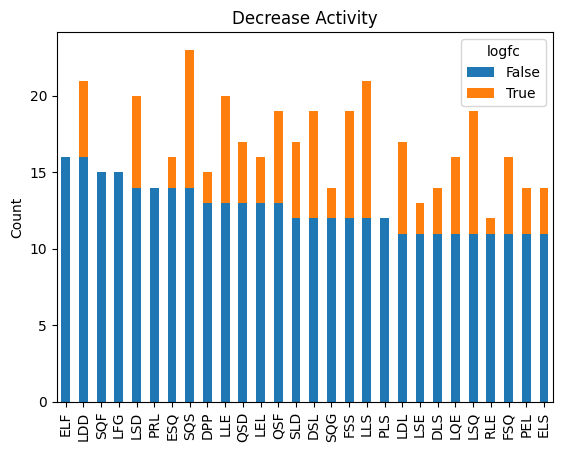

In [97]:
k3 = get_new_kmers(3)
sig_changes = k3.loc[(k3["logfc"] > lfc_thresh) | (k3["logfc"] < -lfc_thresh)]
sig_changes = sig_changes.groupby(sig_changes["logfc"] > lfc_thresh).sum().iloc[:, :-1]
act_ups = sig_changes.loc[:, sig_changes.loc[True] > 10].sort_values(by=True, axis=1, ascending=False).sort_index(ascending=False)
act_ups.T.plot(kind="bar", stacked=True)
# sns.barplot(act_ups,)

plt.xticks(rotation=90, fontsize=8, fontweight="bold")
plt.title("Increase Activity")
plt.ylabel("Count")
plt.legend(title=None)
plt.show()

act_downs = sig_changes.loc[:, sig_changes.loc[False] > 10].sort_values(by=False, axis=1, ascending=False).sort_index(ascending=True)
act_downs.T.plot(kind="bar", stacked=True)
plt.title("Decrease Activity")
plt.ylabel("Count")
plt.show()


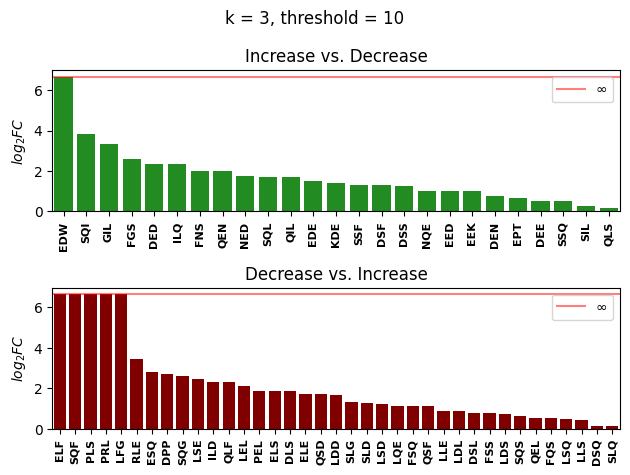

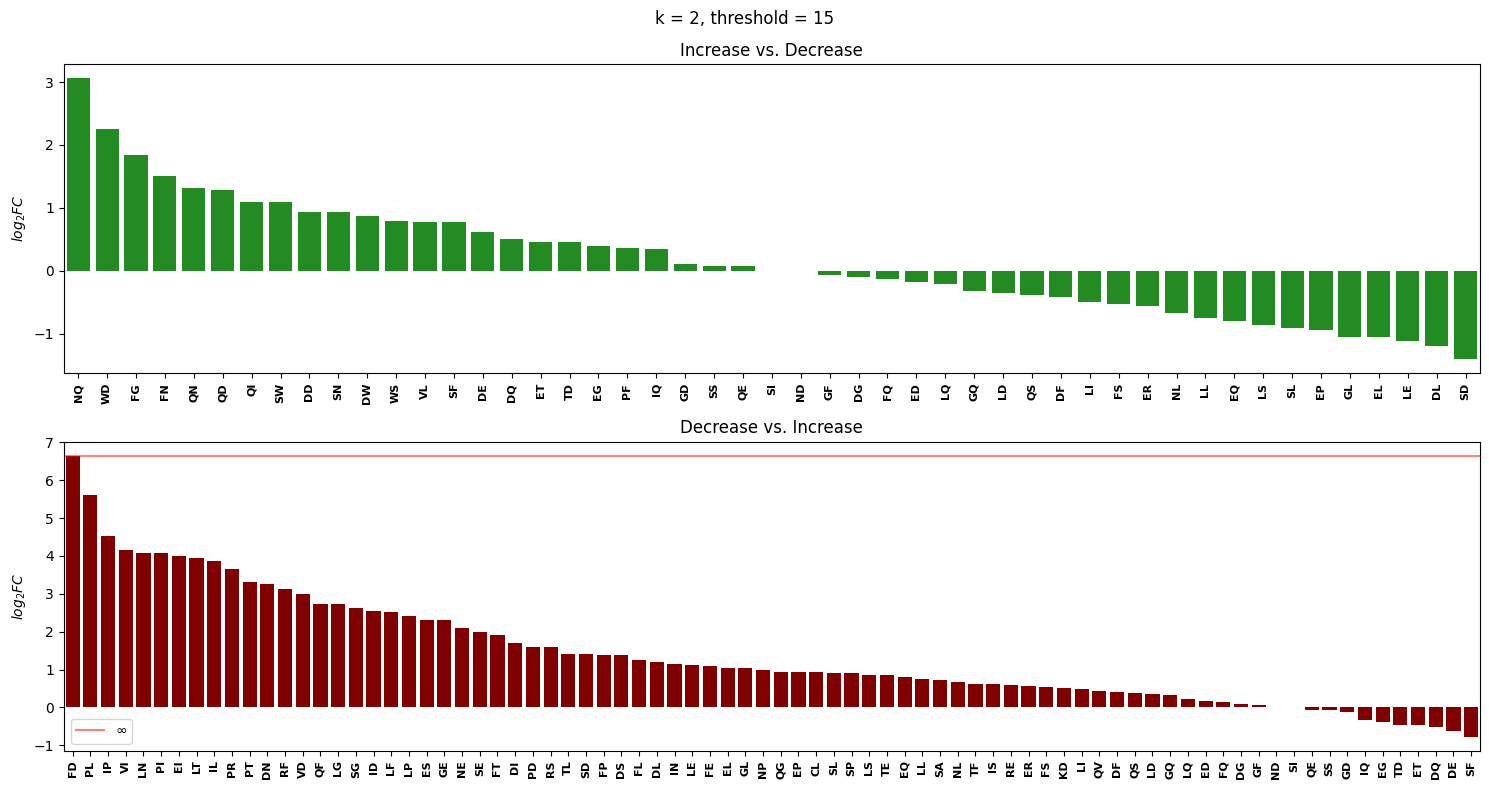

In [142]:
inf_dummy = 100
count_thresh = 7
k = 3
# plt.figure(figsize=(18,10))

def kmer_fc_plot(k, inf_dummy=100, count_thresh=10):
    kdf = get_new_kmers(k)
    sig_changes = kdf.loc[(kdf["logfc"] > lfc_thresh) | (kdf["logfc"] < -lfc_thresh)]
    sig_changes = sig_changes.groupby(sig_changes["logfc"] > lfc_thresh).sum().iloc[:, :-1]
    abundant_kmer_inc_mask = sig_changes.loc[True] >= count_thresh

    kmer_fcs_inc = (sig_changes.loc[True] / sig_changes.loc[False]).apply(lambda x: min(x, inf_dummy)).sort_values(ascending=False)
    kmer_fcs_inc = np.log2(kmer_fcs_inc)[abundant_kmer_inc_mask]
    plt.subplot(2, 1, 1)
    sns.barplot(kmer_fcs_inc, facecolor="forestgreen")
    if any(kmer_fcs_inc == np.log2(inf_dummy)):
        plt.axhline(np.log2(inf_dummy), c='r', alpha=.5, label="∞")
        plt.legend()
    plt.xticks(rotation=90, fontsize=8, fontweight="bold")
    plt.ylabel(r"$log_{2}FC$")
    plt.title("Increase vs. Decrease")


    abundant_kmer_dec_mask = sig_changes.loc[False] >= count_thresh
    kmer_fcs_dec = (sig_changes.loc[False] / sig_changes.loc[True]).apply(lambda x: min(x, inf_dummy)).sort_values(ascending=False)
    kmer_fcs_dec = np.log2(kmer_fcs_dec)[abundant_kmer_dec_mask]
    plt.subplot(2, 1, 2)
    sns.barplot(kmer_fcs_dec, facecolor="maroon")
    if any(kmer_fcs_dec == np.log2(inf_dummy)):
        plt.axhline(np.log2(inf_dummy), c='r', alpha=.5, label="∞")
        plt.legend()
    plt.xticks(rotation=90, fontsize=8, fontweight="bold")
    plt.ylabel(r"$log_{2}FC$")

    plt.title("Decrease vs. Increase")
    plt.suptitle(f"k = {k}, threshold = {count_thresh}")
    plt.tight_layout()
    plt.show()

kmer_fc_plot(3)
plt.figure(figsize=(15,8))
kmer_fc_plot(2, count_thresh=15)

In [113]:
any(kmer_fcs_inc == np.log2(inf_dummy))
kmer_fcs_inc

FVE    6.643856
EEN    6.643856
SWE    6.643856
RKI    6.643856
GWF    6.643856
         ...   
TTF         NaN
STT         NaN
FTK         NaN
TKA         NaN
KAG         NaN
Length: 2737, dtype: float64

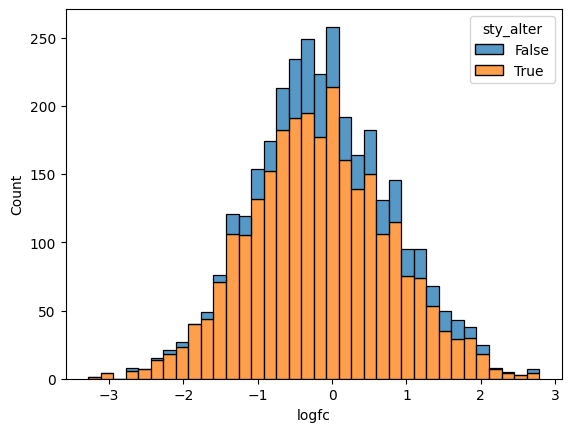

In [248]:
k3 = get_new_kmers(3)
# Get indices where a 3mer including S, T, or Y changes
sty_move_k3 = k3.loc[:, k3.columns.str.contains("S|T|Y")].sum(axis=1) > 0
k3["sty_alter"] = False
k3.loc[sty_move_k3, "sty_alter"] = True
sns.histplot(k3, x="logfc", hue="sty_alter", multiple="stack")
plt.show()

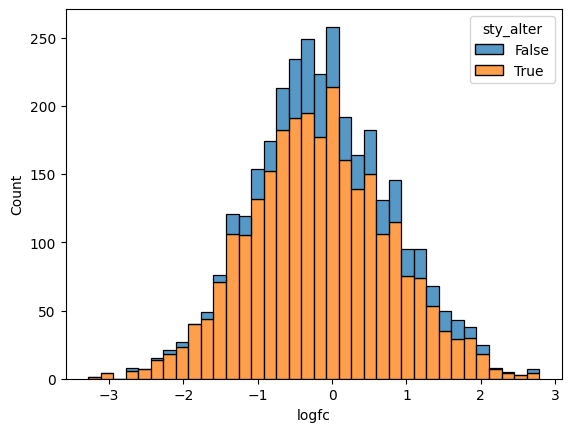

In [ ]:
k3 = get_new_kmers(3)
# Get indices where a 3mer including S, T, or Y changes
sty_move_k3 = k3.loc[:, k3.columns.str.contains("S|T|Y")].sum(axis=1) > 0
k3["sty_alter"] = False
k3.loc[sty_move_k3, "sty_alter"] = True
sns.histplot(k3, x="logfc", hue="sty_alter", multiple="stack")
plt.show()

100

# ESM

Paths:
- `/Users/jack/.cache/torch/hub/checkpoints/esm2_t36_3B_UR50D.pt`

- `/Users/jack/.cache/torch/hub/checkpoints/esm2_t36_3B_UR50D-contact-regression.pt`

In [183]:
import esm
import torch

model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
batch_converter = alphabet.get_batch_converter()
model.eval()



Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t36_3B_UR50D.pt" to /Users/jack/.cache/torch/hub/checkpoints/esm2_t36_3B_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t36_3B_UR50D-contact-regression.pt" to /Users/jack/.cache/torch/hub/checkpoints/esm2_t36_3B_UR50D-contact-regression.pt


ESM2(
  (embed_tokens): Embedding(33, 2560, padding_idx=1)
  (layers): ModuleList(
    (0-35): 36 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=2560, out_features=2560, bias=True)
        (v_proj): Linear(in_features=2560, out_features=2560, bias=True)
        (q_proj): Linear(in_features=2560, out_features=2560, bias=True)
        (out_proj): Linear(in_features=2560, out_features=2560, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=2560, out_features=10240, bias=True)
      (fc2): Linear(in_features=10240, out_features=2560, bias=True)
      (final_layer_norm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=1440, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((2560,), ep

In [189]:
data = [
    ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
    ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
    ("protein3",  "K A <mask> I S Q"),
]
batch_labels, batch_strs, batch_tokens = batch_converter(data)
batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

# Extract per-residue representations (on CPU)
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)
token_representations = results["representations"][33]

In [ ]:
# token_representations.shape


torch.Size([4, 73, 2560])